### Tutorial notebook for doing stacked log-likelihood estimation with LtU-ILI

In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


[Text(0.5, 0, '$\\log M_{200c}$'), Text(0, 0.5, '$N_{\\rm gal}$')]

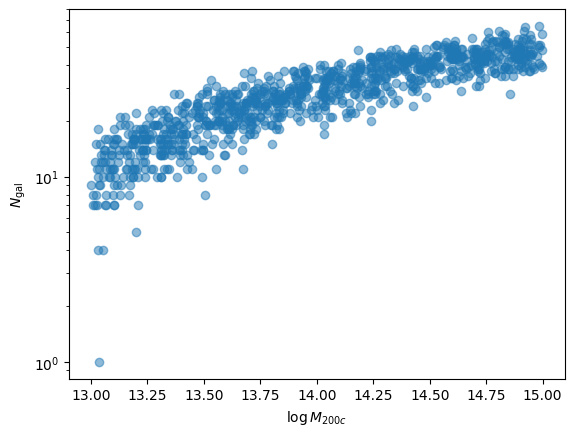

In [54]:
# Let's make some fake data
Nclu = 1000  # number of clusters
mmin, mmax = 13, 15
m200c = np.random.uniform(mmin, mmax, Nclu)  # log halo mass

lambda_gal = 20*(m200c-mmin)+10  # mean of poisson distribution
Ngal = np.random.poisson(lambda_gal)  # number of galaxies

f, ax = plt.subplots()
ax.semilogy(m200c, Ngal, 'o', alpha=0.5)
ax.set(xlabel=r'$\log M_{200c}$', ylabel=r'$N_{\rm gal}$')

[Text(0.5, 0, '$\\log M_{200c}$'), Text(0, 0.5, '$\\sigma_R$')]

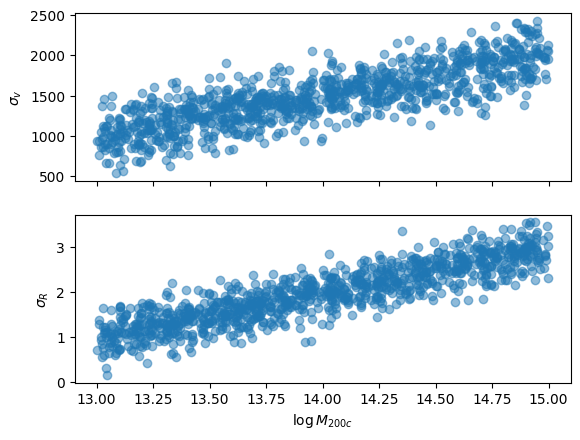

In [55]:
# Let's make some fake spectroscopic observables

sigv = 500*(m200c-mmin)+1000+200*np.random.randn(Nclu)  # velocity dispersion
sigr = 1*(m200c-mmin)+1+0.3*np.random.randn(Nclu)  # projected radius
sigv = np.maximum(sigv, 0)  # make sure it's positive
sigr = np.maximum(sigr, 0)

f, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(m200c, sigv, 'o', alpha=0.5)
axs[0].set(ylabel=r'$\sigma_v$')
axs[1].plot(m200c, sigr, 'o', alpha=0.5)
axs[1].set(xlabel=r'$\log M_{200c}$', ylabel=r'$\sigma_R$')

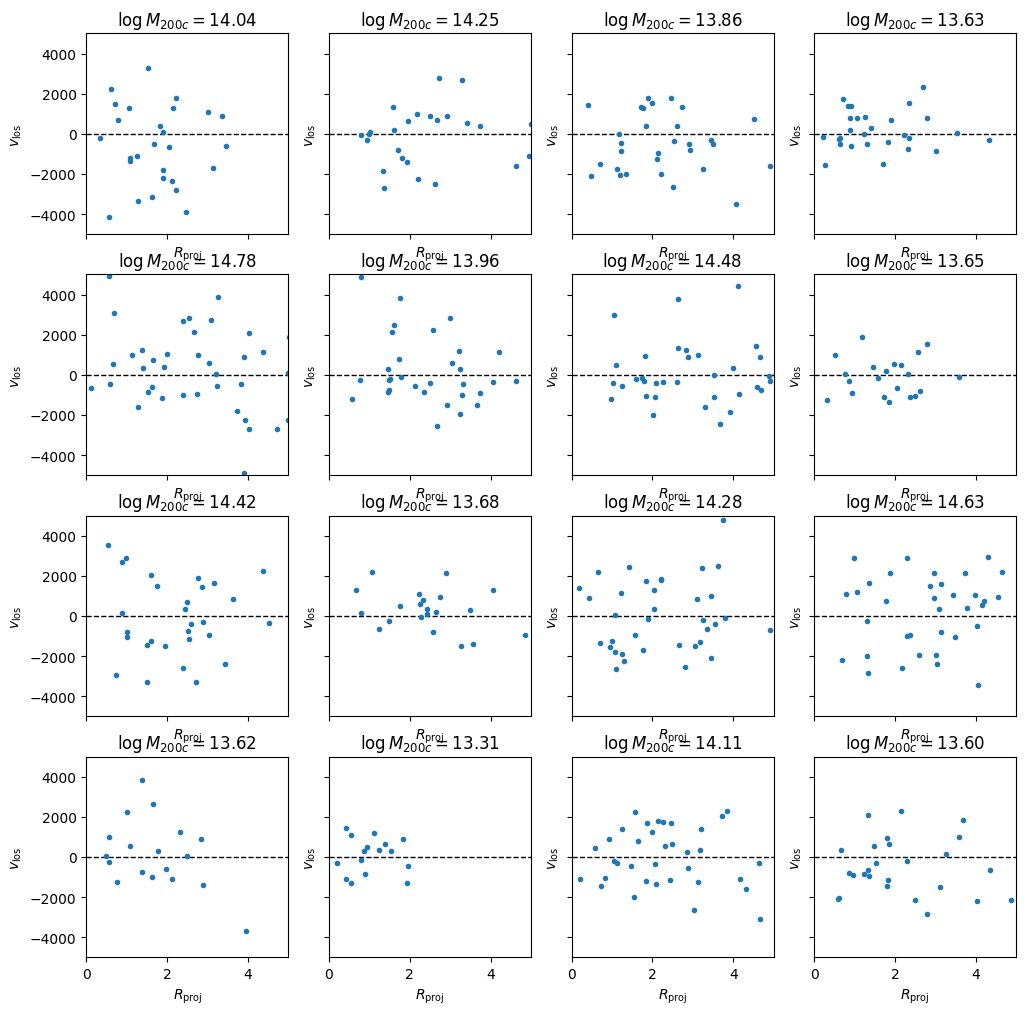

In [56]:
# Let's make some fake dynamical phase-space observables
vlos = [np.random.normal(loc=0, scale=sigv[i], size=Ngal[i])
        for i in range(Nclu)]
xproj = [np.random.normal(loc=0, scale=sigr[i], size=Ngal[i])
         for i in range(Nclu)]
yproj = [np.random.normal(loc=0, scale=sigr[i], size=Ngal[i])
         for i in range(Nclu)]
Rproj = [np.sqrt(xproj[i]**2 + yproj[i]**2) for i in range(Nclu)]

L, W = 4, 4
f, axs = plt.subplots(L, W, figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
for i in range(L*W):
    axs[i].axhline(0, color='k', ls='--', lw=1)
    axs[i].plot(Rproj[i], vlos[i], '.')
    axs[i].set(title=f'$\log M_{{200c}}={m200c[i]:.2f}$',
               xlabel=r'$R_{\rm proj}$', ylabel=r'$v_{\rm los}$')
    axs[i].set_xlim(0, 5)
    axs[i].set_ylim(-5000, 5000)

In [57]:
# We'll only use vlos and Rproj as features
X = [np.stack([vlos[i], Rproj[i]], axis=-1) for i in range(Nclu)]
Y = m200c

# Concatenate all the features together, as individual instances
Xtrain = np.concatenate(X, axis=0)
Ytrain = np.repeat(Y, Ngal).reshape(-1, 1)

# TODO: Split into train/test

In [58]:
# Now let's do some ML!

# make a dataloader
loader = NumpyLoader(x=Xtrain, theta=Ytrain)

# define a prior
prior = ili.utils.Uniform(low=[mmin], high=[mmax], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf',
                           hidden_features=16, num_transforms=4),
    ili.utils.load_nde_sbi(engine='NLE', model='made',
                           hidden_features=16, num_transforms=4),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [59]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NLE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 66

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 44 67 epochs.

INFO:root:It took 174.51924204826355 seconds to train models.


 Neural network successfully converged after 45 epochs.

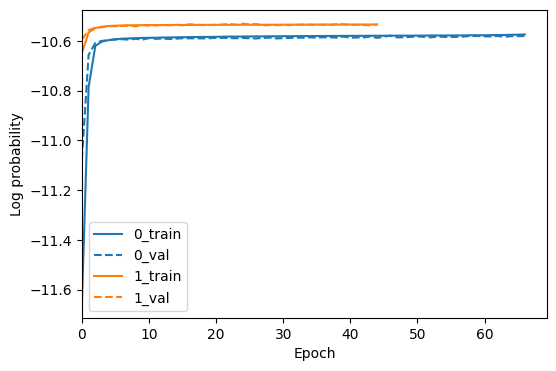

In [60]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6, 4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Running vectorized MCMC with 6 chains:   0%|          | 0/5352 [00:00<?, ?it/s]

Running vectorized MCMC with 6 chains:   0%|          | 0/5850 [00:00<?, ?it/s]

(13.0, 15.0)

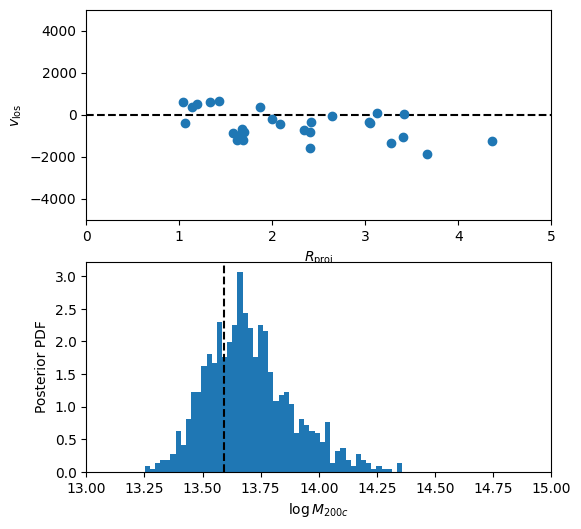

In [97]:
# Plot inference for one cluster
ind = np.random.randint(0, Nclu)
x = X[ind]
y = Y[ind]

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x,
    method='slice_np_vectorized', num_chains=6
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.log_prob(
    samples,
    x
).detach().cpu().numpy()

# plot the posterior
f, axs = plt.subplots(2, 1, figsize=(6, 6))
ax = axs[0]
ax.axhline(0, color='k', ls='--')
ax.plot(x[:, 1], x[:, 0], 'o', label='Data')
ax.set(xlabel=r'$R_{\rm proj}$', ylabel=r'$v_{\rm los}$')
ax.set_xlim(0, 5)
ax.set_ylim(-5000, 5000)

ax = axs[1]
ax.hist(samples[:, 0], bins=50, density=True)
ax.axvline(y, color='k', ls='--')
ax.set(xlabel=r'$\log M_{200c}$', ylabel='Posterior PDF')
ax.set_xlim(mmin, mmax)

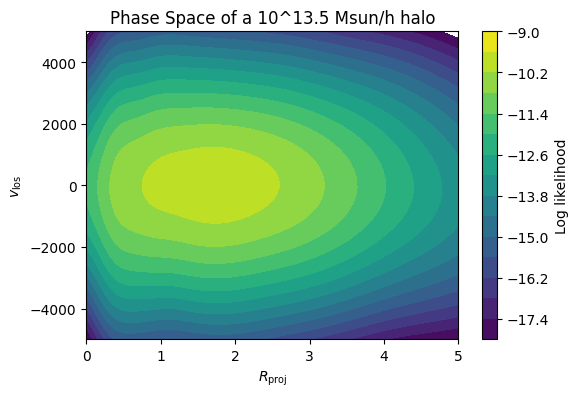

In [94]:
# plot the log-likelihood in phase space
m = 13.5  # this is the learned profile of a 10^13.5 Msun/h halo
v = np.linspace(-5000, 5000, 64)
r = np.linspace(0, 5, 64)
R, V = np.meshgrid(r, v)

log_prob = [
    posterior_ensemble.log_prob(
        [[m]],
        [[v, r]],
    ).detach().cpu().numpy()
    for v, r in zip(V.flatten(), R.flatten())
]
log_prob = np.array(log_prob).reshape(V.shape)

f, ax = plt.subplots(1, 1, figsize=(6, 4))
lev = np.linspace(-18, -9, 16)
c = ax.contourf(R, V, log_prob, levels=lev)
ax.set(xlabel=r'$R_{\rm proj}$', ylabel=r'$v_{\rm los}$',
       title=f'Phase Space of a 10^{m} Msun/h halo')
plt.colorbar(c, label='Log likelihood')